In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from tabulate import tabulate
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("combined_data.csv")
df.tail()

,file_name,report_id,drug_identification_number,brand_name,company_name,common_or_proper_name,ingredients,strength_s,packaging_size,actual_start_date,actual_end_date
19416,2023_Canada_Shortage.xlsx,183684,2373130.0,XYLOCAINE 2% WITH EPINEPHRINE 1:200000,ASPEN PHARMACARE CANADA INC.,lidocaine HCI 2% w/epin. 1:200M 10x20mL MD Vial,EPINEPHRINE\r LIDOCAINE HYDROCHLORIDE,0.005MG\r 20MG,10 vials,NaN,NaN
19417,2023_Canada_Shortage.xlsx,185721,2153432.0,ZINECARD,PFIZER CANADA ULC,ZINECARD,DEXRAZOXANE,250MG,25mL vial,2023-02-28T00:00:00Z,NaN
19418,2023_Canada_Shortage.xlsx,181739,2401606.0,ZOLEDRONIC ACID - Z,SANDOZ CANADA INCORPORATED,ZOLEDRONIC ACID,ZOLEDRONIC ACID,4MG,5ML,2023-01-18T00:00:00Z,2023-01-31T00:00:00Z
19419,2023_Canada_Shortage.xlsx,181295,2132702.0,ZOLOFT,UPJOHN CANADA ULC,ZOLOFT,SERTRALINE,25MG,100,2023-02-06T00:00:00Z,NaN
19420,2023_Canada_Shortage.xlsx,184552,2132702.0,ZOLOFT,UPJOHN CANADA ULC,ZOLFT,SERTRALINE,25MG,100,2023-02-07T00:00:00Z,NaN


In [3]:
df.dtypes

file_name                      object
report_id                       int64
drug_identification_number    float64
brand_name                     object
company_name                   object
common_or_proper_name          object
ingredients                    object
strength_s                     object
packaging_size                 object
actual_start_date              object
actual_end_date                object
dtype: object

In [4]:
df['actual_start_date'] = df['actual_start_date'].astype('datetime64[D]')

In [5]:
df['actual_end_date'] = df['actual_end_date'].astype('datetime64[D]')

In [6]:
df['drug_identification_number'] = df['drug_identification_number'].fillna(0)
df['drug_identification_number'] = df['drug_identification_number'].astype('int')

In [7]:
df.dtypes

file_name                             object
report_id                              int64
drug_identification_number             int32
brand_name                            object
company_name                          object
common_or_proper_name                 object
ingredients                           object
strength_s                            object
packaging_size                        object
actual_start_date             datetime64[ns]
actual_end_date               datetime64[ns]
dtype: object

In [8]:
df=df.dropna(subset=['actual_start_date','actual_end_date'] )

In [9]:
df=df.drop_duplicates("report_id", keep=False)

In [10]:
df['Days']= df['actual_end_date']-df['actual_start_date']

In [11]:
df['Days2'] = df['Days'].dt.days
df['Days2']=df['Days2'].astype('int')

In [12]:
# 
df['file_name'] = df['file_name'].str[0:4]

In [13]:
df.to_csv("data.csv", index=False)

In [14]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11427 entries, 1 to 19418
Columns: 13 entries, file_name to Days2
dtypes: datetime64[ns](2), int32(2), int64(1), object(7), timedelta64[ns](1)
memory usage: 1.1+ MB


In [15]:
din = df['drug_identification_number'].mode()
din

0    717002
dtype: int32

In [16]:
col_list = ['actual_start_date', 'Days2']
df2 = df[col_list]
df2 = df2.loc[(df['actual_start_date'] >= '2017-01-01')]


In [17]:
df2

,actual_start_date,Days2
1,2017-11-15,6
2,2018-03-01,28
4,2018-01-19,42
6,2017-11-17,122
8,2017-09-13,428
...,...,...
19389,2023-01-09,9
19405,2023-01-26,19
19406,2023-01-11,34
19410,2023-01-31,7


In [18]:
df2['actual_start_date'] = df2['actual_start_date'].astype('datetime64[D]')

In [19]:
df2.dtypes

actual_start_date    datetime64[ns]
Days2                         int32
dtype: object

In [20]:
df2=df2.dropna(subset=['actual_start_date','Days2'] )


In [21]:
df2.set_index('actual_start_date', inplace=True)

In [22]:
df2.head()

,Days2
actual_start_date,
2017-11-15,6
2018-03-01,28
2018-01-19,42
2017-11-17,122
2017-09-13,428


In [23]:
#Split the dataset for training and testing dataset
# train = df2.loc[df2.index < 2022-01-01]
train = df2.loc[df2.index < "2022-01-01"]
test = df2.loc[df2.index >= "2022-01-01"]

In [52]:
result = adfuller(df2['Days2'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.614924
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


<AxesSubplot:xlabel='actual_start_date'>

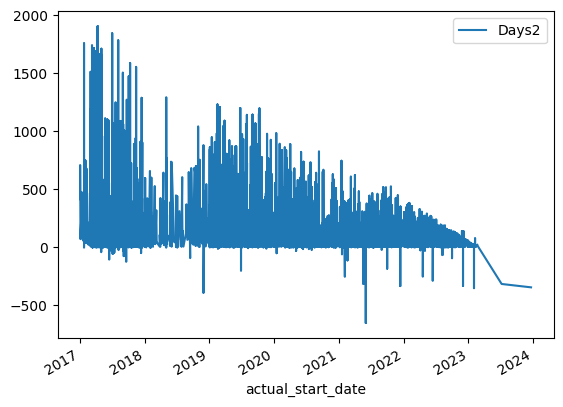

In [51]:
df2.plot()

In [25]:
# If the time series is not stationary, apply differencing to make it stationary
if result[1] > 0.05:
    diff = df2['Days2'].diff().dropna()
else:
    diff = df2['Days2']

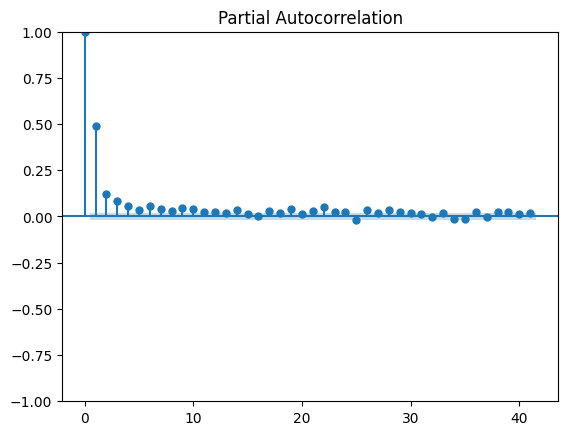

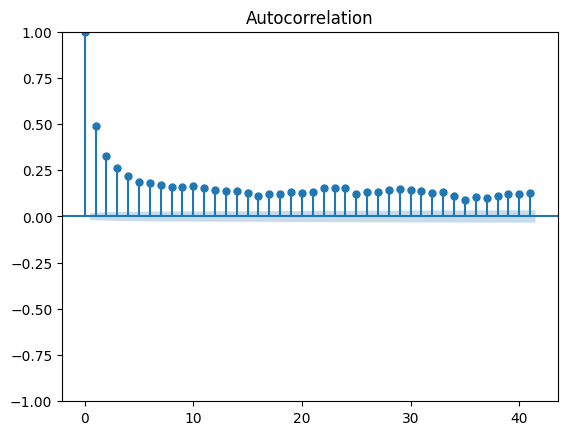

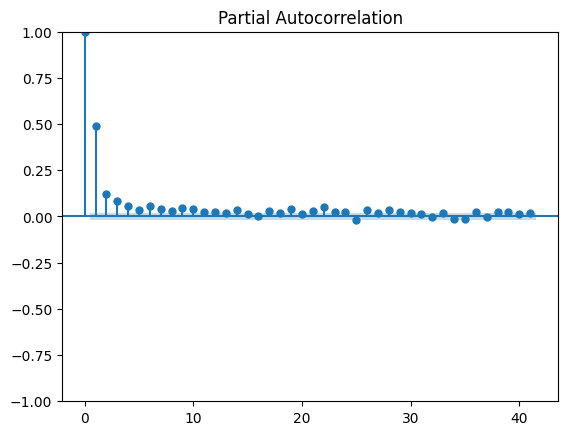

In [26]:
plot_acf(diff)
plot_pacf(diff)

In [27]:
p = 1
d = 1
q = 1

In [28]:
# train_size = int(len(diff) * .8)
# train, test = diff[:train_size], diff[train_size:]

In [29]:
model = ARIMA(train, order=(p,d,q))
model_fit = model.fit()

C:\Users\sagar\anaconda3\envs\DAB300\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sagar\anaconda3\envs\DAB300\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sagar\anaconda3\envs\DAB300\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sagar\anaconda3\envs\DAB300\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates

In [30]:
predictions = model_fit.forecast(steps=len(test))

C:\Users\sagar\anaconda3\envs\DAB300\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [31]:
predictions.shape

(2137,)

In [32]:
mse = mean_squared_error(test, predictions)
print("Mean Squared Error (MSE): {:.2f}".format(mse))


Mean Squared Error (MSE): 5618.05


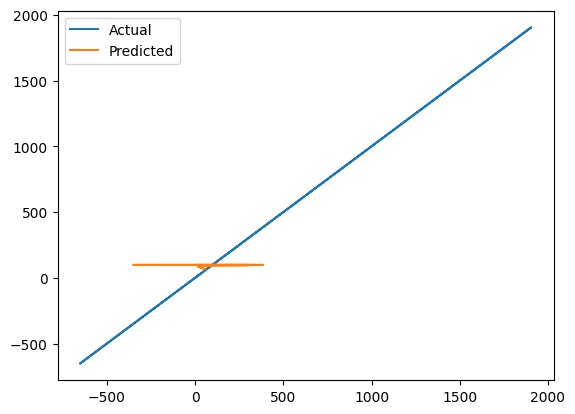

In [38]:
# Plot the actual vs predicted values
# plt.plot(df2.index[:test], test, label='Actual')
plt.plot(df2.loc[df2.index < "2022-01-01"], train, label='Actual')
# df2.loc[df2.index < "2022-01-01"]
plt.plot(df2.loc[df2.index >= "2022-01-01"], predictions, label='Predicted')
plt.legend()
plt.show()

In [50]:
predictions

9001     65.832189
9002     85.253470
9003     93.139083
9004     96.340875
9005     97.640897
           ...    
11133    98.529573
11134    98.529573
11135    98.529573
11136    98.529573
11137    98.529573
Name: predicted_mean, Length: 2137, dtype: float64